In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn

import torch
from sklearn.model_selection import train_test_split

cuda = torch.cuda.is_available()
print("GPU:", cuda)

GPU: True


In [2]:
train = pd.read_csv("data/train.csv")

In [3]:
#Splitting train dataset into X and Y.Normalizing it by dividing it with 255

X = train.iloc[:,1:].values / 255
Y = train.iloc[:,0].values

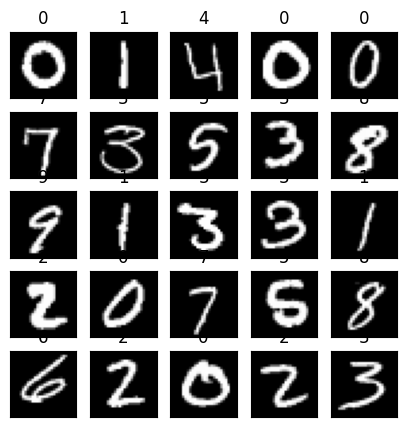

In [4]:
#visulaizing numbers in our dataset.
r = 5
c = 5
fig=plt.figure(figsize=(r, c),dpi=100)
for i in range(1, r*c+1):
    img = X[i].reshape(28,28)
    ax = fig.add_subplot(r, c, i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(Y[i])
    
    plt.imshow(img,cmap='gray')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

trn_x,val_x,trn_y,val_y = train_test_split(X,Y,test_size=0.2)

In [7]:
#converting our data into a datloader object.

trn_x = torch.from_numpy(trn_x).type(torch.FloatTensor)
trn_y = torch.from_numpy(trn_y).type(torch.LongTensor)

val_x = torch.from_numpy(val_x).type(torch.FloatTensor)
val_y = torch.from_numpy(val_y).type(torch.LongTensor)

In [8]:
from torch.utils.data import TensorDataset,DataLoader

trn = TensorDataset(trn_x,trn_y)
val = TensorDataset(val_x,val_y)

trn = DataLoader(trn,batch_size=64)
val = DataLoader(val,batch_size=64)

In [9]:
shape = trn_x[0].shape
shape

torch.Size([784])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)

mlp = Model()

if cuda:
    mlp.cuda()
    
print(mlp)    

In [ ]:
#define our optimizer
from torch.optim import Adam

optimizer = Adam(mlp.parameters(), lr=1e-3)

In [ ]:
import torch
import torch.nn.functional as F

def calculate_metrics(model, trn, val):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    with torch.no_grad():
        model.eval()
        for inputs, labels in trn:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = F.nll_loss(outputs, labels)
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
    
    train_loss /= len(trn)
    train_acc = 100. * train_correct / train_total
    
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        model.eval()
        for inputs, labels in val:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = F.nll_loss(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_loss /= len(val)
    val_acc = 100. * val_correct / val_total
    
    return train_acc, val_acc, train_loss, val_loss


In [ ]:
epochs = 10
